In [123]:
import pandas as pd
import numpy as np
import copy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import scipy as sc
import plotly.graph_objects as go
import sqlite3
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import pypfopt.plotting as plotting
import seaborn as sns



In [124]:
end_date = datetime.today()
start_date = end_date - timedelta(days=3000)
tickers = ['SPY','META', 'AAPL','LLY', 'GIS', 'XOM']
weights = [10,20,20,10,25,15]

In [125]:
# Import data
def getData(tickers:list, start_date:datetime, end_date:datetime):
    
    df = yf.download( tickers,
                    start=start_date,
                    end = end_date
                    )
    df = df['Adj Close']
    
    # mu = mean_historical_return(df)
    # S = CovarianceShrinkage(df).ledoit_wolf()
    # returns = df.pct_change()
    # meanReturns = returns.mean()
    # covMatrix = returns.cov()
    return df

df = getData(tickers, start_date, end_date)

# calculate daily and annual returns of the stocks
returns_daily = df.pct_change()
returns_annual = returns_daily.mean() * 252

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,GIS,LLY,META,SPY,XOM
Date,,,,,,
2014-12-29,25.594793,41.094158,58.701942,80.019997,180.305740,63.885002
2014-12-30,25.282469,41.124413,58.316730,79.220001,179.338226,63.850662
2014-12-31,24.801628,40.352627,57.772411,78.019997,177.558563,63.459419
2015-01-02,24.565693,40.186161,58.668427,78.449997,177.463593,63.720242
2015-01-05,23.873644,39.459770,58.090626,77.190002,174.258698,61.976749


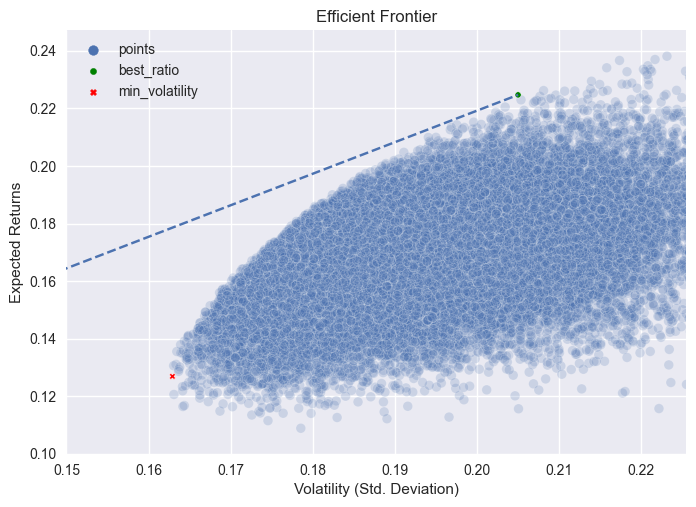

In [172]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(tickers)
num_portfolios = 40000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
            'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(tickers):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' weight' for stock in tickers]

# reorder dataframe columns
df = df[column_order]



df['tags'] = 'points'

# min_volatility = df[df['Volatility']==df['Volatility'].min()].iloc[:,-len(tickers):].to_dict()
min_vol_index = (df['Volatility']==df['Volatility'].min())
df.loc[min_vol_index,'tags'] = 'min_volatility'
df.loc[min_vol_index]

max_ratio_index = (df['Returns']/df['Volatility']).idxmax()
df.loc[max_ratio_index, 'tags'] = 'best_ratio'
df.loc[max_ratio_index]

tg = df.loc[(df['Returns']/df['Volatility']).idxmax()]


x_tg = [0,tg['Volatility']]
y_tg = [0,tg['Returns']]
# plot the efficient frontier with a scatter plot

ax = sns.scatterplot(data=df[df.tags=='points'], x='Volatility', y='Returns', hue='tags', alpha=0.2)

sns.scatterplot(data=df[df.tags!='points'], x='Volatility', y='Returns' , hue='tags', alpha=1, palette=["green","red"], size='tags',size_order=['min_volatility','best_ratio' ], sizes=(20,20), style = 'tags')
sns.lineplot(x=x_tg, y=y_tg , linestyle='--')


# Set the axis limits
plt.xlim(0.15, max(x_tg) * 1.1)  # add some padding to the left and right
plt.ylim(0.10, max(y_tg) * 1.1)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()


In [127]:
df.tail()

,Returns,Volatility,SPY weight,META weight,AAPL weight,LLY weight,GIS weight,XOM weight
49995,0.163124,0.182749,0.091072,0.240647,0.195844,0.182937,0.278097,0.011403
49996,0.159532,0.182372,0.020266,0.062795,0.313604,0.052557,0.411404,0.139373
49997,0.175140,0.229602,0.205881,0.023712,0.072742,0.329868,0.286453,0.081344
49998,0.150869,0.185658,0.033265,0.230046,0.204845,0.151148,0.013536,0.367160
49999,0.137363,0.180247,0.004288,0.318239,0.128988,0.172322,0.039213,0.336949


0.24795139105946323

Returns              0.172261
Volatility           0.182632
SPY weight           0.282103
META weight          0.238542
AAPL weight          0.125457
LLY weight           0.045703
GIS weight           0.223653
XOM weight           0.084542
tags           min_volatility
Name: 0, dtype: object

Returns          0.225549
Volatility       0.206624
SPY weight       0.396422
META weight      0.145666
AAPL weight      0.389967
LLY weight       0.036623
GIS weight        0.00406
XOM weight       0.027263
tags           best_ratio
Name: 36607, dtype: object